## Pretrained GAN

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='0' 

In [2]:
import fastai
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from fastai.vision.gan import *
from fasterai.generators import *
from fasterai.tensorboard import *
from fasterai.dataset import *

In [3]:
path = Path('data/imagenet/ILSVRC/Data/CLS-LOC')
path_hr = path
path_lr = path/'bandw'

proj_id = 'ColorizeNew1a'
TENSORBOARD_PATH = Path('data/tensorboard/' + proj_id)

## Crappified data

Prepare the input data by crappifying images.

In [4]:
from PIL import Image, ImageDraw, ImageFont

In [5]:
def crappify(fn,i):
    dest = path_lr/fn.relative_to(path_hr)
    dest.parent.mkdir(parents=True, exist_ok=True)
    img = PIL.Image.open(fn).convert('LA').convert('RGB')
    img.save(dest)  

Uncomment the first time you run this notebook.

In [ ]:
#il = ImageItemList.from_folder(path_hr)
#parallel(crappify, il.items)

For gradual resizing we can change the commented line here.

In [6]:
bs,size=32, 128
# bs,size = 24,160
#bs,size = 8,256
arch = models.resnet34

## Pre-train generator

Now let's pretrain the generator.

In [7]:
arch = models.resnet34

In [8]:
def get_data(bs:int, sz:int, keep_pct:float):
    return get_colorize_data(sz=sz, bs=bs, crappy_path=path_lr, good_path=path_hr, 
                             random_seed=None, keep_pct=keep_pct,num_workers=32)

In [9]:
data_gen = get_data(bs,size,0.1)

In [10]:
wd = 1e-3

In [11]:
y_range = (-3.,3.)

In [12]:
loss_gen = FeatureLoss(gram_wgt=5e3)

In [13]:
def create_gen_learner():
    return unet_learner2(data_gen, arch, wd=wd, blur=True, norm_type=NormType.Spectral,
                         self_attention=True, y_range=y_range, loss_func=loss_gen)

In [14]:
learn_gen = create_gen_learner()

In [ ]:
learn_gen.fit_one_cycle(8, pct_start=0.8)

In [ ]:
learn_gen.unfreeze()

In [ ]:
learn_gen.fit_one_cycle(12, slice(1e-6,1e-3))

In [ ]:
learn_gen.show_results(rows=4)

In [ ]:
learn_gen.save('gen-pre-a')

## Save generated images

In [ ]:
learn_gen.load('gen-pre-a');

In [15]:
name_gen = 'image_gen-a'
path_gen = path/name_gen

In [ ]:
# shutil.rmtree(path_gen)

In [ ]:
path_gen.mkdir(exist_ok=True)

In [16]:
def save_preds(dl):
    i=0
    names = dl.dataset.items
    
    for b in dl:
        preds = learn_gen.pred_batch(batch=b, reconstruct=True)
        for o in preds:
            o.save(path_gen/names[i].name)
            i += 1

In [ ]:
save_preds(data_gen.fix_dl)

In [ ]:
PIL.Image.open(path_gen.ls()[0])

## Train critic

In [ ]:
learn_gen=None
gc.collect()

Pretrain the critic on crappy vs not crappy.

In [17]:
def get_crit_data(classes, bs, size):
    src = ImageItemList.from_folder(path, include=classes, recurse=True).random_split_by_pct(0.1, seed=42)
    ll = src.label_from_folder(classes=classes)
    data = (ll.transform(get_transforms(max_zoom=2.), size=size)
           .databunch(bs=bs).normalize(imagenet_stats))
    return data

In [18]:
data_crit = get_crit_data([name_gen, 'test'], bs=bs, size=size)

In [ ]:
data_crit.show_batch(rows=3, ds_type=DatasetType.Train, imgsize=3)

In [19]:
loss_critic = AdaptiveLoss(nn.BCEWithLogitsLoss())

In [20]:
def create_critic_learner(data, metrics):
    learner = Learner(data, gan_critic(), metrics=metrics, loss_func=loss_critic, wd=wd)
    return learner

In [ ]:
learn_critic = create_critic_learner(data_crit, accuracy_thresh_expand)

In [ ]:
learn_critic.fit_one_cycle(6, 1e-3)

In [ ]:
learn_critic.save('critic-pre-a')

## GAN

Now we'll combine those pretrained model in a GAN.

In [21]:
learn_crit=None
learn_gen=None
gc.collect()

70

In [22]:
#placeholder- not actually used
data_crit = get_crit_data([name_gen, 'test'], bs=bs, size=size)

In [23]:
learn_crit = create_critic_learner(data_crit, metrics=None).load('critic-pre-a')

In [24]:
learn_gen = create_gen_learner().load('gen-pre-a')

To define a GAN Learner, we just have to specify the learner objects foor the generator and the critic. The switcher is a callback that decides when to switch from discriminator to generator and vice versa. Here we do as many iterations of the discriminator as needed to get its loss back < 0.5 then one iteration of the generator.

The loss of the critic is given by `learn_crit.loss_func`. We take the average of this loss function on the batch of real predictions (target 1) and the batch of fake predicitions (target 0). 

The loss of the generator is weighted sum (weights in `weights_gen`) of `learn_crit.loss_func` on the batch of fake (passed throught the critic to become predictions) with a target of 1, and the `learn_gen.loss_func` applied to the output (batch of fake) and the target (corresponding batch of superres images).

In [25]:
switcher = partial(AdaptiveGANSwitcher, critic_thresh=0.65)
learn = GANLearner.from_learners(learn_gen, learn_crit, weights_gen=(1.0,2.0), show_img=False, switcher=switcher,
                                 opt_func=partial(optim.Adam, betas=(0.,0.99)), wd=wd)
learn.callback_fns.append(partial(GANDiscriminativeLR, mult_lr=5.))
learn.callback_fns.append(partial(GANTensorboardWriter, base_dir=TENSORBOARD_PATH, name='GanLearner', visual_iters=100))

In [26]:
lr = 1e-4

In [27]:
learn.fit(10,lr)

epoch,train_loss,gen_loss,disc_loss
1,2.379875,2.873108,5.505718
2,2.811065,2.761532,5.553720
3,2.738256,2.824781,5.499640
4,2.859388,3.033478,5.513911
5,2.711472,2.928353,5.522888
6,2.925939,2.512365,5.521295


KeyboardInterrupt: 

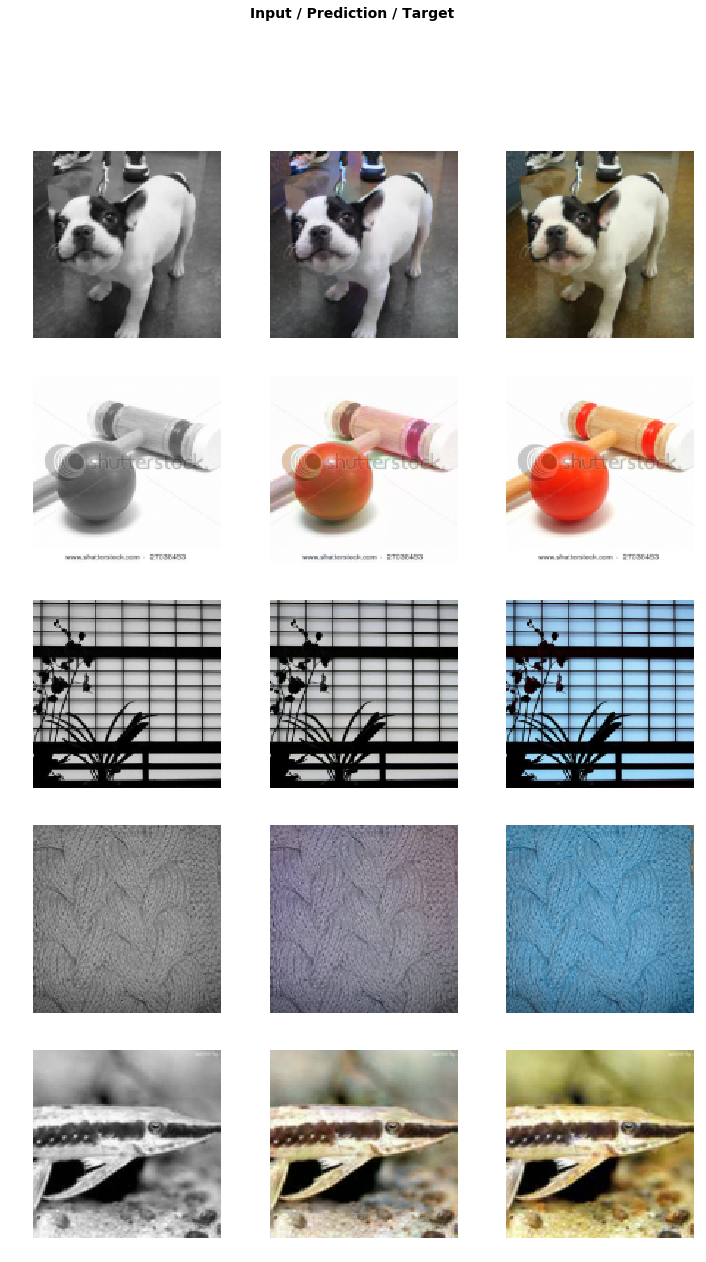

In [28]:
learn.show_results()

In [29]:
learn.save('gan-a')

In [ ]:
learn.load('gan-a')

In [31]:
learn.data=get_data(14,192,0.1)

In [34]:
learn.fit(10,lr/2)

epoch,train_loss,gen_loss,disc_loss
1,2.260538,2.246810,4.527203


KeyboardInterrupt: 

In [ ]:
learn.show_results(rows=14)

In [33]:
learn_gen.save('gen-pre-a')
learn_crit.save('crit-pre-a')

In [ ]:
learn.data=get_data(7,256,0.1)

In [ ]:
learn.fit(10,lr/4)

In [ ]:
learn_gen.save('gen-pre-a')
learn_crit.save('crit-pre-a')

In [ ]:
learn.show_results(rows=7)

In [ ]:
learn.fit(20,lr/40)

In [ ]:
learn_gen.save('gen-pre-a')
learn_crit.save('crit-pre-a')

In [ ]:
learn.data=get_data(16,256,0.1)

In [ ]:
learn.show_results(rows=14)

In [ ]:
learn.data=get_data(32,192,0.1)

In [ ]:
learn.show_results(rows=32)

## fin